<a href="https://colab.research.google.com/github/lqiang67/generative_models_examples/blob/main/mixture_regression_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

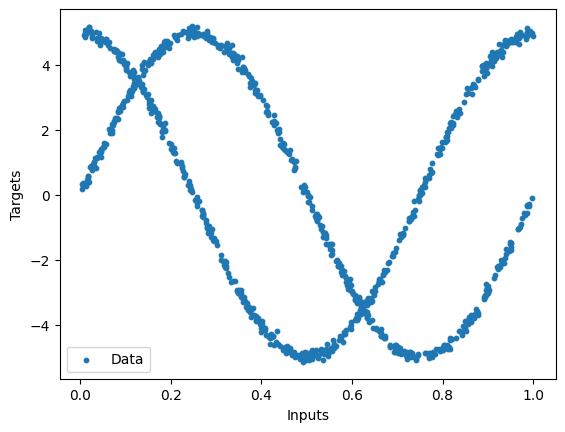

In [ ]:
#@title Generating a toy data
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define the nonlinear functions
def f1(x):
    return 5*np.sin(2 * np.pi * x)

def f2(x):
    return 5*np.cos(2 * np.pi * x)

# Generate the dataset
np.random.seed(42)
num_samples = 1000
x = np.random.uniform(0, 1, num_samples)
U = np.random.uniform(0, 1, num_samples)
y = (U <0.5) * np.random.normal(f1(x), 0.1) + (U>=0.5) * np.random.normal(f2(x), 0.1)

# Convert to PyTorch tensors
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create a custom Dataset class
class ToyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create a DataLoader
dataset = ToyDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Plot the generated dataset
plt.scatter(x, y, s=10, label='Data')
plt.xlabel('Inputs')
plt.ylabel('Targets')
plt.legend()
plt.show()


Epoch [50/1000], Loss: 6.3564
Epoch [100/1000], Loss: 6.2065
Epoch [150/1000], Loss: 6.1060
Epoch [200/1000], Loss: 6.1450
Epoch [250/1000], Loss: 6.1124
Epoch [300/1000], Loss: 6.1889
Epoch [350/1000], Loss: 6.0766
Epoch [400/1000], Loss: 6.1587
Epoch [450/1000], Loss: 6.1213
Epoch [500/1000], Loss: 6.1812
Epoch [550/1000], Loss: 6.0676
Epoch [600/1000], Loss: 6.1718
Epoch [650/1000], Loss: 6.1172
Epoch [700/1000], Loss: 6.1329
Epoch [750/1000], Loss: 6.1257
Epoch [800/1000], Loss: 6.1137
Epoch [850/1000], Loss: 6.0955
Epoch [900/1000], Loss: 6.0989
Epoch [950/1000], Loss: 6.0805
Epoch [1000/1000], Loss: 6.0457


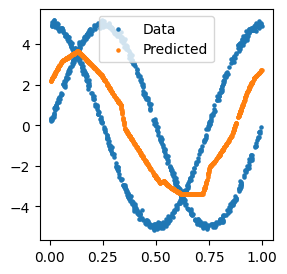

In [ ]:
#@title Least square regression
# It only estimates the conditional, can not explain the uncertainty

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# set up
input_dim = output_dim = 1
model = nn.Sequential(nn.Linear(input_dim, 64),nn.ReLU(),nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, output_dim))
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = torch.mean((y_pred - y_batch)**2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

# Plotting the results
model.eval()
plt.figure(figsize=(3,3))
plt.scatter(x_train.squeeze(), y_train.squeeze(), label='Data', s=5)
y_pred = model(x_train)
plt.scatter(x_train.squeeze().detach().numpy(), y_pred.squeeze().detach().numpy(),  label='Predicted', s=5)
plt.legend()
plt.show()


In [22]:
#@title GMM head
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

class MatrixLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Args:
            input_dim (int): The size of each input sample.
            output_dim (list): The dimensions of the output tensor.
        """
        super(MatrixLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.output_flatten_dim = int(torch.prod(torch.tensor(output_dim)))

        # Create a weight matrix with shape [input_dim, output_flatten_dim]
        self.linear = nn.Linear(input_dim, self.output_flatten_dim)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input tensor of shape (batch_size, context_length, input_dim)
        Returns:
            Tensor: Output tensor of shape (batch_size, context_length, *output_dim)
        """
        y = self.linear(x)
        output = y.view(*y.shape[:-1], *self.output_dim)
        return output


class GMM(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_components,
                 base = nn.Identity(),
                 sigma_lower_bound = 1e-6):
        super(GMM, self).__init__()
        self.num_components = num_components
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.base = base
        self.log_pi_head = nn.Linear(hidden_dim, num_components)
        self.log_sigma_head = MatrixLinear(hidden_dim, [num_components, output_dim])
        self.mu_head = MatrixLinear(hidden_dim, [num_components, output_dim])
        self.sigma_lower_bound = sigma_lower_bound

    def forward(self, x, y=None):
        x = self.base(x)
        log_pi = torch.nn.functional.log_softmax(self.log_pi_head(x), dim=1)
        mu = self.mu_head(x)
        log_sigma = self.log_sigma_head(x)
        gmm_params =  {'log_pi': log_pi,  'log_sigma': log_sigma, 'mu': mu}

        if y is None:
            return gmm_params
        else:
            loss = self.nll_loss(gmm_params,  y)
            return  gmm_params, loss

    def sample(self, x, num_samples=5):
        gmm_params = self.forward(x)
        log_pi = gmm_params['log_pi']
        log_sigma = gmm_params['log_sigma']
        mu = gmm_params['mu']

        pi = torch.exp(log_pi)
        sigma = torch.exp(log_sigma) + self.sigma_lower_bound
        categorical = torch.distributions.Categorical(pi)
        component_index = categorical.sample((num_samples,))
        component_index = component_index.unsqueeze(-1).unsqueeze(-1)

        #mu_expanded: num_samples * Batch * Length * Components * Dim
        #component:   num_samples * Batch * Length * 1 * 1
        selected_mu = torch.gather(mu.unsqueeze(0).expand(num_samples, *mu.size()), -2, component_index).squeeze(2)
        selected_sigma = torch.gather(sigma.unsqueeze(0).expand(num_samples, *mu.size()), -2, component_index).squeeze(2)

        normal = torch.distributions.Normal(selected_mu, selected_sigma)
        samples = normal.rsample()

        return samples

    # Negative log-likelihood loss
    def nll_loss(self, gmm_params, y, reduction='mean'):
        log_pi, log_sigma, mu = gmm_params['log_pi'], gmm_params['log_sigma'], gmm_params['mu']
        if y.dim() < mu.dim(): y = y.unsqueeze(-2)
        sigma = torch.exp(log_sigma) + self.sigma_lower_bound
        logp = torch.sum(-0.5*((y- mu)**2/sigma**2) - log_sigma, dim=-1) + log_pi
        nll = -torch.logsumexp(logp, dim = -1)

        if reduction == 'mean':
            return torch.mean(nll)
        elif reduction == 'none':
            return nll
        elif reduction == 'sum':
            return torch.sum(nll)
        else:
            raise ValueError(f"Invalid reduction mode: {reduction}")




Epoch [50/200], Loss: 1.1436
Epoch [100/200], Loss: 1.0868
Epoch [150/200], Loss: 1.0772
Epoch [200/200], Loss: 1.0709


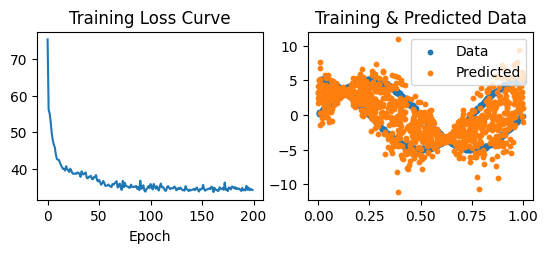

In [23]:
#@title Gaussian regression
gmm_input_dim = 1
gmm_output_dim = 1
num_components = 1
hidden_dim = 64

x, y = next(iter(dataloader))

backbone = nn.Sequential(nn.Linear(gmm_input_dim, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),)
model = GMM(hidden_dim, gmm_output_dim, num_components, base = backbone)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200

loss_curve = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        _, loss = model(x_batch, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_curve.append(total_loss)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

# Plotting the results
model.eval()

x_test = torch.rand_like(x_train)
y_pred = model.sample(x_test, num_samples=1)

plt.subplot(221)
plt.plot(loss_curve)
plt.xlabel('Epoch')
plt.title('Training Loss Curve')

plt.subplot(222)
plt.scatter(x_train, y_train, label='Data', s=10)
plt.scatter(x_test.squeeze().detach().numpy(), y_pred.squeeze().detach().numpy(), label='Predicted', s=10);
plt.title('Training & Predicted Data')
plt.legend()

Epoch [50/200], Loss: 0.4920
Epoch [100/200], Loss: -0.6785
Epoch [150/200], Loss: -0.7278
Epoch [200/200], Loss: -0.7442


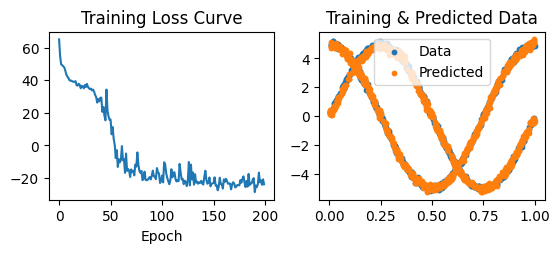

In [25]:
#@title GMM regression
gmm_input_dim = 1
gmm_output_dim = 1
num_components = 2
hidden_dim = 64

x, y = next(iter(dataloader))

backbone = nn.Sequential(nn.Linear(gmm_input_dim, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),)
model = GMM(hidden_dim, gmm_output_dim, num_components, base = backbone)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200

loss_curve = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        _, loss = model(x_batch, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_curve.append(total_loss)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

# Plotting the results
model.eval()

x_test = torch.rand_like(x_train)
y_pred = model.sample(x_test, num_samples=1)

plt.subplot(221)
plt.plot(loss_curve)
plt.xlabel('Epoch')
plt.title('Training Loss Curve')

plt.subplot(222)
plt.scatter(x_train, y_train, label='Data', s=10)
plt.scatter(x_test.squeeze().detach().numpy(), y_pred.squeeze().detach().numpy(), label='Predicted', s=10);
plt.title('Training & Predicted Data')
plt.legend()